In [ ]:
%load_ext autoreload
%autoreload 2

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from DataParser import DataParser
from NaiveBayes import NaiveBayes

import numpy as np
import matplotlib.pyplot as plt

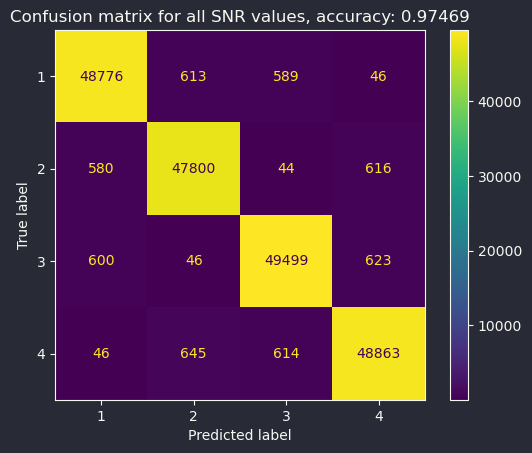

In [24]:
dataSet = DataParser("../data/DataForML.mat")
train_data, train_labels = dataSet.get_train_dataV1()
test_data, test_labels = dataSet.get_test_dataV1()

naiveBayes = NaiveBayes()
naiveBayes.train(train_data, train_labels, np.unique(train_labels))

predicted_labels = naiveBayes.predict(test_data, np.unique(train_labels))


ConfusionMatrixDisplay.from_predictions(test_labels.flatten(), predicted_labels.flatten(),)
plt.title(f"Confusion matrix for all SNR values, accuracy: {np.mean(predicted_labels == test_labels)}")
plt.show()



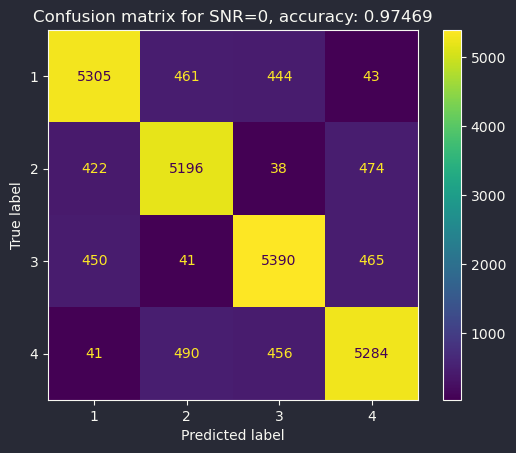

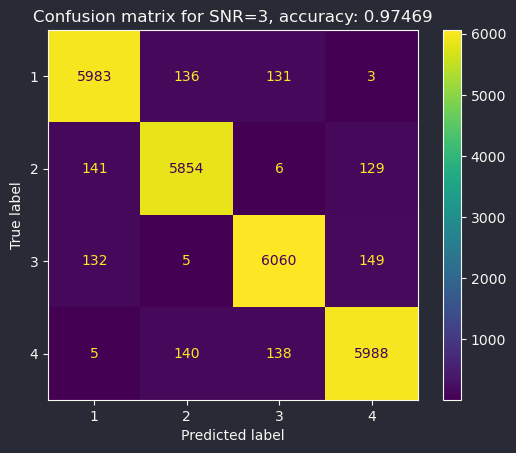

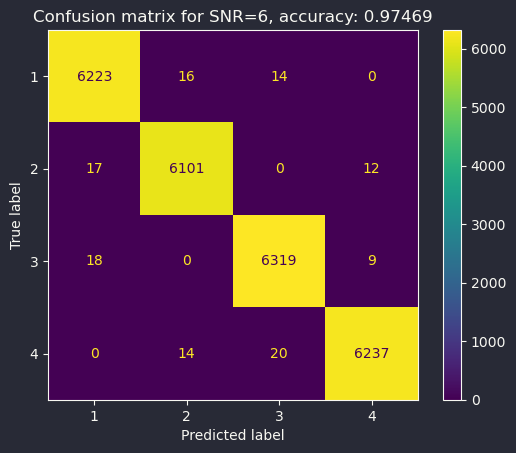

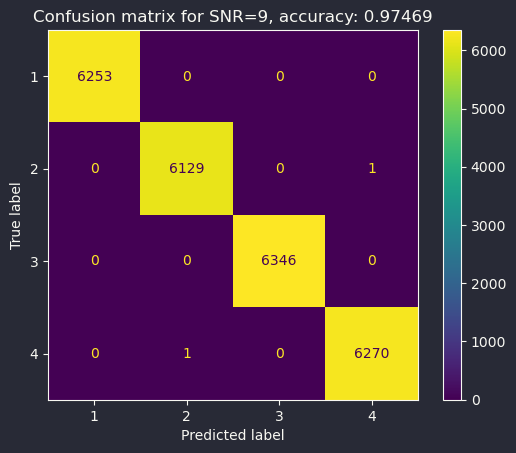

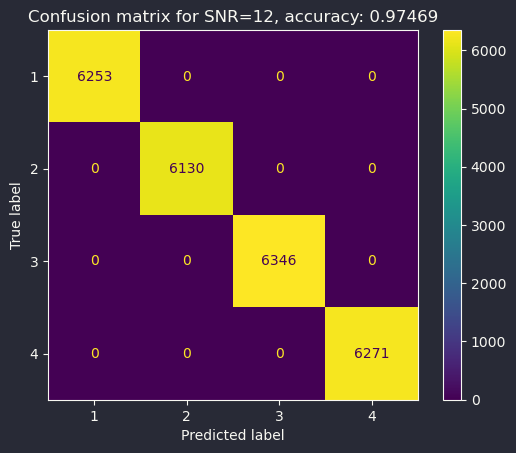

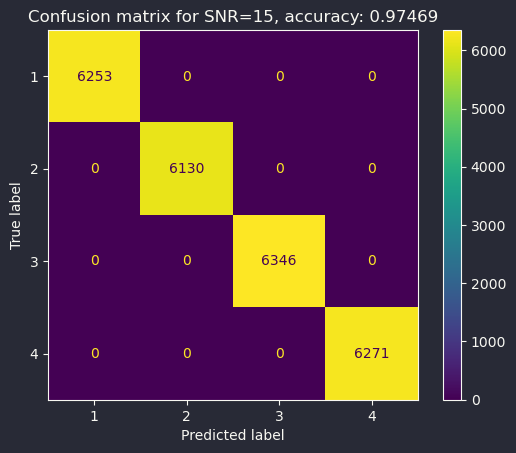

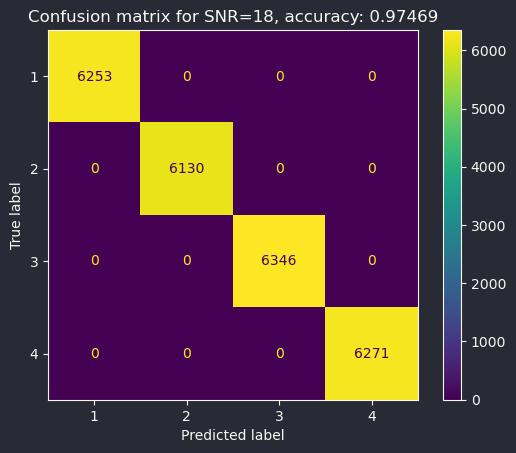

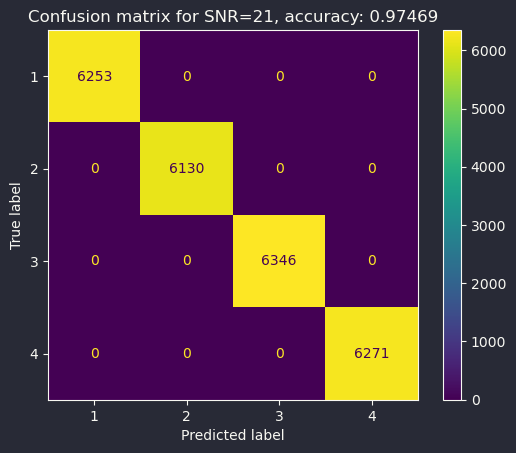

In [25]:
accuracy = np.zeros(8)
for i in range(8):
    accuracy[i] = np.mean(predicted_labels == test_labels)
    ConfusionMatrixDisplay.from_predictions(test_labels[i].flatten(), predicted_labels[i].flatten(),)
    plt.title(f"Confusion matrix for SNR={dataSet.SNR[i]}, accuracy: {accuracy[i]}")
    plt.show()
